<a href="https://colab.research.google.com/github/Magd-ayyad10/twitter-sentiment-analysis/blob/main/RNN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Define column names
col_names = ['TweetID', 'Entity', 'Sentiment', 'Content']

# Load datasets
try:
    df_train = pd.read_csv('twitter_training.csv', names=col_names, header=None)
    df_test = pd.read_csv('twitter_test.csv', names=col_names, header=None)
except FileNotFoundError:
    print("Make sure 'twitter_training.csv' and 'twitter_test.csv' are in the same directory.")
    # Create empty dataframes to avoid further errors in notebook execution
    df_train = pd.DataFrame(columns=col_names)
    df_test = pd.DataFrame(columns=col_names)

print("Training Data Head:")
display(df_train.head())

print("\nTest Data Head:")
display(df_test.head())

Training Data Head:


,TweetID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...



Test Data Head:


,TweetID,Entity,Sentiment,Content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [3]:
print("Training Data Info:")
df_train.info()

print("\nTest Data Info:")
df_test.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetID    74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetID    1000 non-null   int64 
 1   Entity     1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Content    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [4]:
#Handling missing values
print(f"Original training shape: {df_train.shape}")
df_train.dropna(subset=['Content', 'Sentiment'], inplace=True)
print(f"New training shape: {df_train.shape}")

print(f"\nOriginal test shape: {df_test.shape}")
df_test.dropna(subset=['Content', 'Sentiment'], inplace=True)
print(f"New test shape: {df_test.shape}")

Original training shape: (74682, 4)
New training shape: (73996, 4)

Original test shape: (1000, 4)
New test shape: (1000, 4)


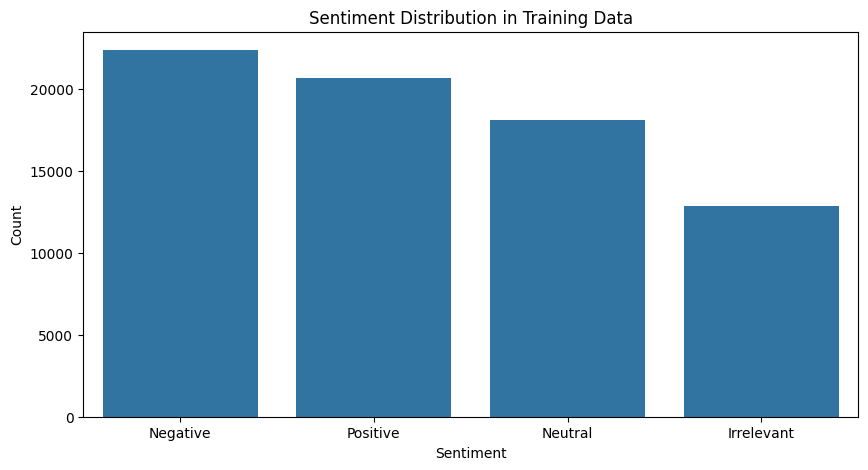

In [5]:
#Analyze sentiment distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, x='Sentiment', order=df_train['Sentiment'].value_counts().index)
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [6]:
#Text processing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Ensure text is a string
    text = str(text)

    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove user mentions
    text = re.sub(r'@[^\s]+', '', text)

    # 4. Remove hashtags (keeping the text of the hashtag)
    text = re.sub(r'#', '', text)

    # 5. Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # 6. & 7. Remove stop words and lemmatize
    tokens = []
    for word in text.split():
        if word not in stop_words:
            tokens.append(lemmatizer.lemmatize(word))

    return ' '.join(tokens)

In [7]:
# Apply the cleaning function to our data
print("Cleaning training data...")
df_train['Clean_Content'] = df_train['Content'].apply(clean_text)

print("Cleaning test data...")
df_test['Clean_Content'] = df_test['Content'].apply(clean_text)

print("\nCleaning complete. Here's a sample:")
display(df_train[['Content', 'Clean_Content']].head())


Cleaning training data...
Cleaning test data...

Cleaning complete. Here's a sample:


,Content,Clean_Content
0,im getting on borderlands and i will murder yo...,im getting borderland murder
1,I am coming to the borders and I will kill you...,coming border kill
2,im getting on borderlands and i will kill you ...,im getting borderland kill
3,im coming on borderlands and i will murder you...,im coming borderland murder
4,im getting on borderlands 2 and i will murder ...,im getting borderland murder


In [8]:
#encoding data
encoder = LabelEncoder()
# Fit on training data and transform both training and test data
df_train['Sentiment_Encoded'] = encoder.fit_transform(df_train['Sentiment'])
df_test['Sentiment_Encoded'] = encoder.transform(df_test['Sentiment'])

# Get the mapping
print("Label mapping:")
for i, class_name in enumerate(encoder.classes_):
    print(f"{class_name}: {i}")

num_classes = len(encoder.classes_)
print(f"\nTotal number of classes: {num_classes}")

display(df_train[['Sentiment', 'Sentiment_Encoded']].head())

Label mapping:
Irrelevant: 0
Negative: 1
Neutral: 2
Positive: 3

Total number of classes: 4


,Sentiment,Sentiment_Encoded
0,Positive,3
1,Positive,3
2,Positive,3
3,Positive,3
4,Positive,3


In [9]:
#Text tokentization and padding

# Model parameters
VOCAB_SIZE = 20000
MAX_LENGTH = 100
EMBEDDING_DIM = 64 # Dimension for the embedding layer
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOK = '<OOV>'

# Initialize and fit the tokenizer on the training text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(df_train['Clean_Content'])

# --- Prepare Training Data ---
# Convert text to sequences
X_train_full_seq = tokenizer.texts_to_sequences(df_train['Clean_Content'])
# Pad sequences
X_train_full_pad = pad_sequences(X_train_full_seq, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
y_train_full = df_train['Sentiment_Encoded'].values

# --- Prepare Test Data ---
# Convert text to sequences
X_test_seq = tokenizer.texts_to_sequences(df_test['Clean_Content'])
# Pad sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
y_test = df_test['Sentiment_Encoded'].values

print("\nShape of padded training data (X):", X_train_full_pad.shape)
print("Shape of training labels (y):", y_train_full.shape)
print("Shape of padded test data (X):", X_test_pad.shape)
print("Shape of test labels (y):", y_test.shape)


Shape of padded training data (X): (73996, 100)
Shape of training labels (y): (73996,)
Shape of padded test data (X): (1000, 100)
Shape of test labels (y): (1000,)


In [10]:
#Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_pad,
    y_train_full,
    test_size=0.1,
    random_state=42,
    stratify=y_train_full # Ensure class balance in split
)

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)


Training data shape: (66596, 100) (66596,)
Validation data shape: (7400, 100) (7400,)


In [11]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

# Callback for early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
# model 1 simple RNN
model_rnn = Sequential([
    # Input layer: Embedding
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),

    # Hidden layer: SimpleRNN
    SimpleRNN(32),

    # Output layer: Dense
    Dense(num_classes, activation='softmax')
])

model_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_rnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - accuracy: 0.3751 - loss: 1.3200 - val_accuracy: 0.5174 - val_loss: 1.1531
Epoch 2/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.5894 - loss: 1.0417 - val_accuracy: 0.5205 - val_loss: 1.1719
Epoch 3/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - accuracy: 0.6693 - loss: 0.8939 - val_accuracy: 0.6488 - val_loss: 0.9404
Epoch 4/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.7412 - loss: 0.7202 - val_accuracy: 0.6938 - val_loss: 0.8476
Epoch 5/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.7878 - loss: 0.6015 - val_accuracy: 0.7123 - val_loss: 0.8102
Epoch 6/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.8112 - loss: 0.5402 - val_accuracy: 0.7208 - val_loss: 0.7905
Epoch 7/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.8328 - loss: 0.4817 - val_accuracy: 0.7230 - val_loss: 0.8095
Epoch 8/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.8396 -

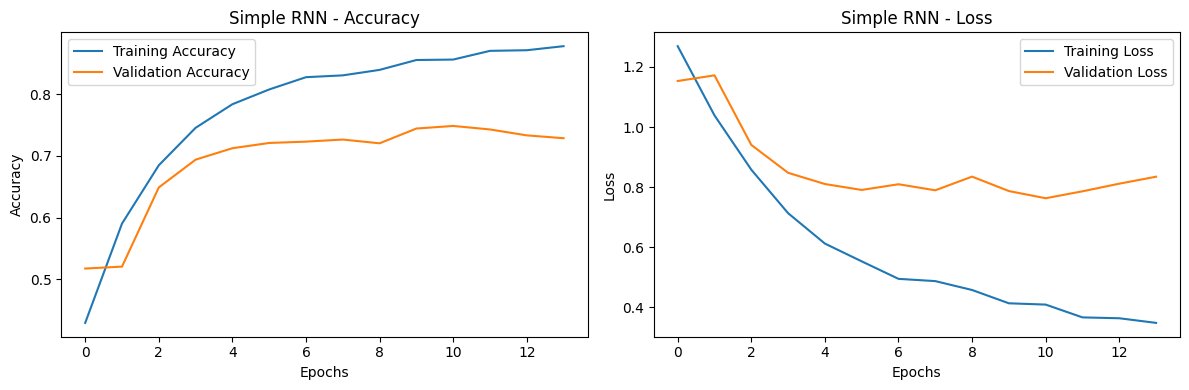

--- Evaluating Simple RNN on Test Data ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8981 - loss: 0.2960
Test Accuracy: 0.8980
Test Loss: 0.3200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.94      0.78      0.85       172
    Negative       0.88      0.94      0.91       266
     Neutral       0.91      0.90      0.90       285
    Positive       0.89      0.92      0.90       277

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.90      0.90      1000



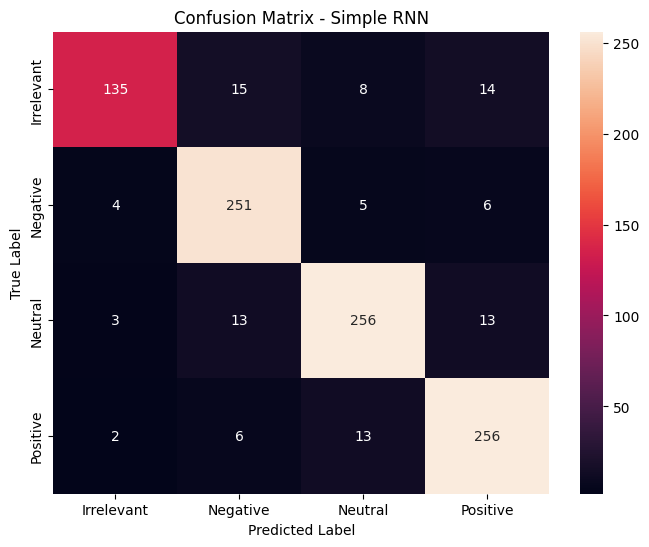

In [14]:
plot_history(history_rnn, "Simple RNN")

print("--- Evaluating Simple RNN on Test Data ---")
test_loss_rnn, test_acc_rnn = model_rnn.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_acc_rnn:.4f}")
print(f"Test Loss: {test_loss_rnn:.4f}")

# Get predictions
y_pred_rnn_probs = model_rnn.predict(X_test_pad)
y_pred_rnn = np.argmax(y_pred_rnn_probs, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rnn, target_names=encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rnn), annot=True, fmt='d',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - Simple RNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
#Model 2 LSTM
model_lstm = Sequential([
    # Input layer: Embedding
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),

    # Hidden layer: LSTM
    LSTM(64), # Using 64 units for more capacity

    # Output layer: Dense
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 84s 81ms/step - accuracy: 0.3009 - loss: 1.3672 - val_accuracy: 0.3022 - val_loss: 1.3666
Epoch 2/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 80s 77ms/step - accuracy: 0.3042 - loss: 1.3662 - val_accuracy: 0.3022 - val_loss: 1.3666
Epoch 3/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 84s 78ms/step - accuracy: 0.3033 - loss: 1.3667 - val_accuracy: 0.3022 - val_loss: 1.3667
Epoch 4/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 79s 76ms/step - accuracy: 0.3009 - loss: 1.3670 - val_accuracy: 0.3023 - val_loss: 1.3667


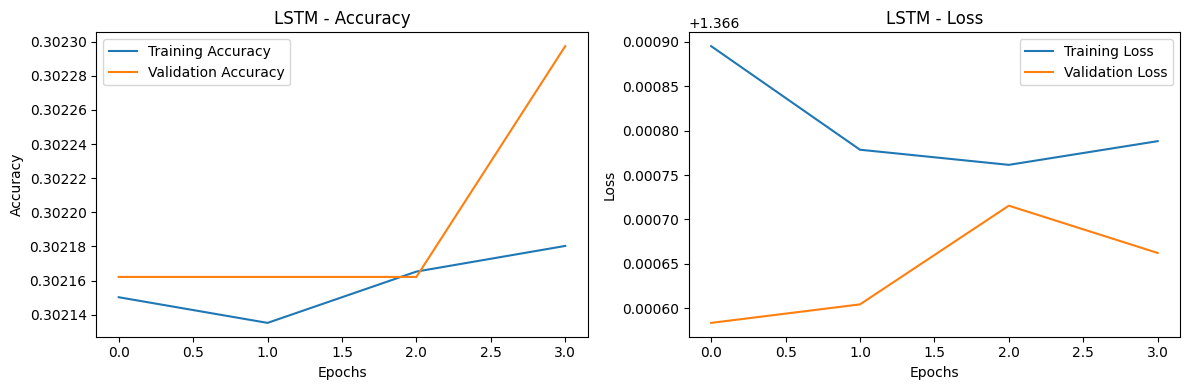

--- Evaluating LSTM on Test Data ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2743 - loss: 1.3674
Test Accuracy: 0.2660
Test Loss: 1.3734
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00       172
    Negative       0.27      1.00      0.42       266
     Neutral       0.00      0.00      0.00       285
    Positive       0.00      0.00      0.00       277

    accuracy                           0.27      1000
   macro avg       0.07      0.25      0.11      1000
weighted avg       0.07      0.27      0.11      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


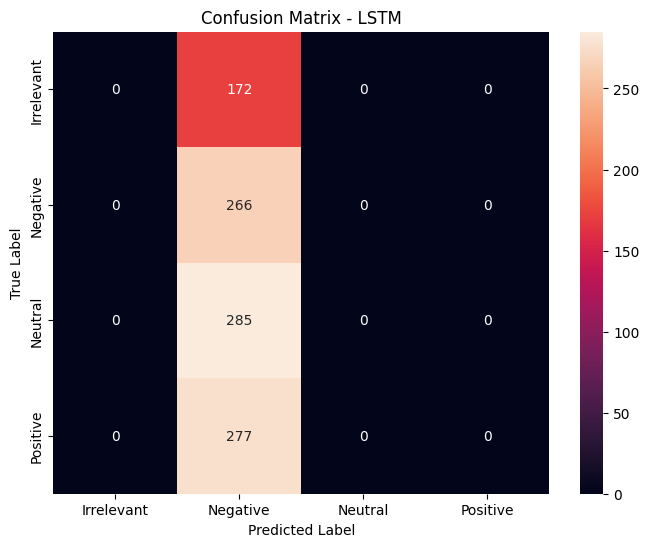

In [23]:
plot_history(history_lstm, "LSTM")

print("--- Evaluating LSTM on Test Data ---")
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_acc_lstm:.4f}")
print(f"Test Loss: {test_loss_lstm:.4f}")

# Get predictions
y_pred_lstm_probs = model_lstm.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm_probs, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lstm), annot=True, fmt='d',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
#model 3 bidirectional LSTM
model_bilstm = Sequential([
    # Input layer: Embedding
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),

    # Hidden layer: Bidirectional LSTM
    Bidirectional(LSTM(64, return_sequences=True)),

    # Pooling layer to reduce dimensionality
    GlobalMaxPool1D(),

    # A fully-connected hidden layer
    Dense(32, activation='relu'),
    Dropout(0.3),

    # Output layer: Dense
    Dense(num_classes, activation='softmax')
])

model_bilstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_bilstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/10
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 148s 139ms/step - accuracy: 0.5084 - loss: 1.1289 - val_accuracy: 0.7774 - val_loss: 0.6116
Epoch 2/10
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 217s 154ms/step - accuracy: 0.8244 - loss: 0.4939 - val_accuracy: 0.8314 - val_loss: 0.4613
Epoch 3/10
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 147s 141ms/step - accuracy: 0.8839 - loss: 0.3250 - val_accuracy: 0.8422 - val_loss: 0.4314
Epoch 4/10
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 203s 142ms/step - accuracy: 0.9025 - loss: 0.2637 - val_accuracy: 0.8576 - val_loss: 0.4318
Epoch 5/10
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 147s 141ms/step - accuracy: 0.9188 - loss: 0.2176 - val_accuracy: 0.8604 - val_loss: 0.4583
Epoch 6/10
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 202s 142ms/step - accuracy: 0.9298 - loss: 0.1845 - val_accuracy: 0.8618 - val_loss: 0.4720


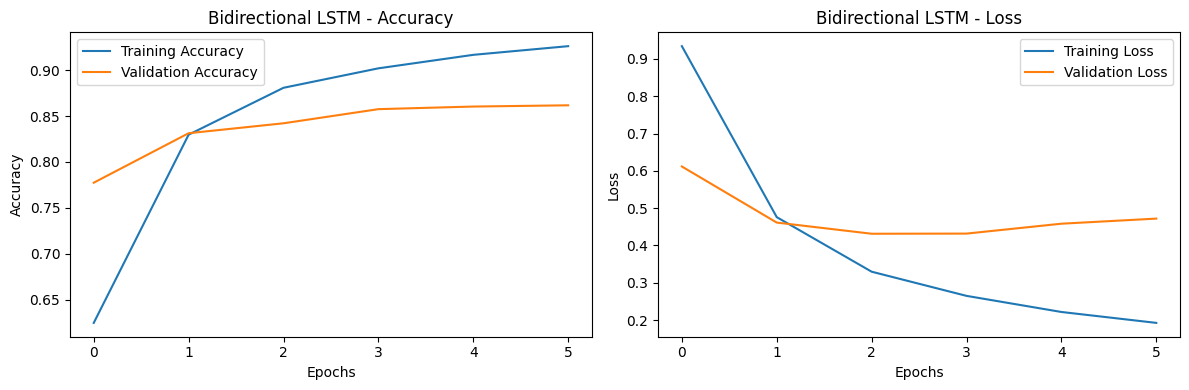

--- Evaluating Bidirectional LSTM on Test Data ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9225 - loss: 0.2289
Test Accuracy: 0.9230
Test Loss: 0.2357
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.91      0.90      0.90       172
    Negative       0.92      0.95      0.94       266
     Neutral       0.95      0.91      0.93       285
    Positive       0.90      0.92      0.91       277

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



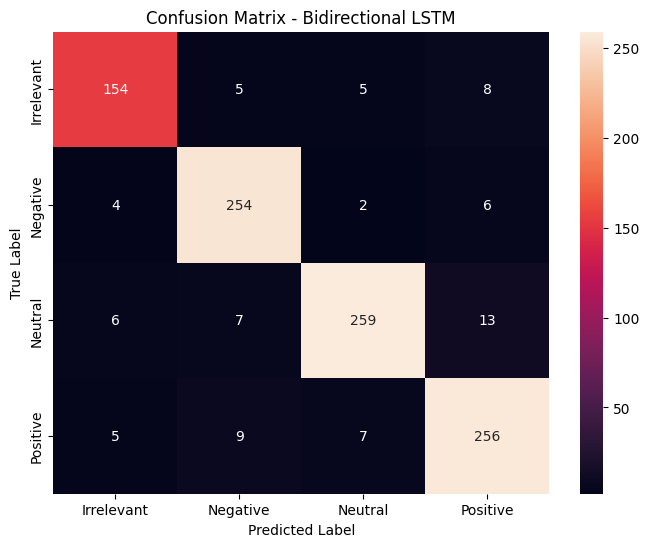

In [20]:
plot_history(history_bilstm, "Bidirectional LSTM")

print("--- Evaluating Bidirectional LSTM on Test Data ---")
test_loss_bilstm, test_acc_bilstm = model_bilstm.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_acc_bilstm:.4f}")
print(f"Test Loss: {test_loss_bilstm:.4f}")

# Get predictions
y_pred_bilstm_probs = model_bilstm.predict(X_test_pad)
y_pred_bilstm = np.argmax(y_pred_bilstm_probs, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bilstm, target_names=encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_bilstm), annot=True, fmt='d',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - Bidirectional LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

--- Model Comparison on Test Data ---
Simple RNN Accuracy:      0.8980
LSTM Accuracy:            0.2660
Bidirectional LSTM Accuracy: 0.9230


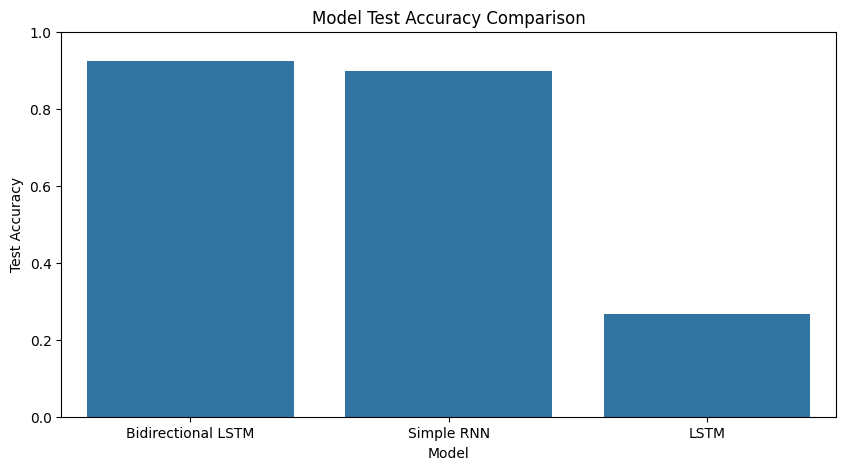

In [24]:
#Conclusion
print("--- Model Comparison on Test Data ---")
print(f"Simple RNN Accuracy:      {test_acc_rnn:.4f}")
print(f"LSTM Accuracy:            {test_acc_lstm:.4f}")
print(f"Bidirectional LSTM Accuracy: {test_acc_bilstm:.4f}")

results_df = pd.DataFrame({
    'Model': ['Simple RNN', 'LSTM', 'Bidirectional LSTM'],
    'Test Accuracy': [test_acc_rnn, test_acc_lstm, test_acc_bilstm]
})

results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='Test Accuracy')
plt.title('Model Test Accuracy Comparison')
plt.ylim(0, 1.0)
plt.show()
